In [1]:
#importing libraries and setting the graphics parameters 
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 95
db = wrds.Connection(wrds_username="djolitto")

Loading library list...
Done


In [2]:
#variables
#downloading data setting up the query 
stocks  = db.raw_sql("""
                      select b.ticker, a.permno, a.date, b.shrcd, b.exchcd, a.ret, a.shrout, a.prc
                      from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and a.date<=b.nameendt
                      where a.date between '01/01/1980' and '12/31/2021' and b.exchcd between 1 and 2  and b.shrcd between 10 and 11  """, date_cols=['date'])

df = stocks.drop(['shrcd','exchcd'],axis=1)   #dropping columns that we won't use 
df['one'] = 1    #adding a constant columns used to count obs for each stock 
df = df.sort_values(['permno','date'])   #sorting the dataframe 
obs =(df.groupby('permno').sum()).one    #calculating the number of observations for each stock 
permno_to_keep = obs.index[obs>=504].to_list()   #list of stocks to keep 

#new dataframe 
data = pd.DataFrame()
#list that we use to insert the Series to keep giving the fact that pandas prefer to 
#concatenate all the series in one step and than recursively adding one series at each step 
series = [ ]   

for i in (permno_to_keep):
    s = df[df.permno == i].ret   #selecting the returns
    s = s.reset_index()     
    s = s.drop(columns="index")   #we do not need the index columns
    s[i] = s.ret     # setting a columns with the index equal to the permno
    series.append( s[i] )    #adding this series in the list created 
        
        
data = pd.concat(series, axis=1)   #concatenating all the series in the dataFrame 
date = df[df.permno == permno_to_keep[0]].date.values  #from the first series to keep we take the date to set as index 
data = data.set_index(date)  #setting the index 


#downloading the risk free asset  
tbill = db.raw_sql("select  mcaldt,tmytm from crsp.tfz_mth_rf "           
                   "where kytreasnox = 2000001 and mcaldt>='1980-01-01'"
                   "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

#downloading the market portfolio return 
vw_market = db.raw_sql("select date,vwretd from crsp.msi where date >= '1980-01-01' and date <= '2021-12-31'", date_cols =["date"])


tbill["tmytm"] = np.exp(tbill['tmytm']/12/100) - 1  #adjusting the risk free asset to have simple returns monthly 
tbill = tbill.rename(columns={"mcaldt":"date", "tmytm":"rf"})   #changing the columns name 
tbill = tbill.set_index(date)   #we set the same index 
tbill = tbill.drop(columns= "date")  
#we have dates in the index, we do not need this columns 
vw_market = vw_market.set_index(date)
vw_market = vw_market.drop(columns="date")


#visualizing the dataset obtained 
print(data.head())

             10516.0   10866.0   10874.0   10890.0   11308.0   11404.0  \
1980-01-31  0.182186  0.053922  0.071028  0.004785  0.018116 -0.039381   
1980-02-29 -0.032877 -0.088372  0.061947 -0.080952 -0.064057 -0.060773   
1980-03-31 -0.187943 -0.040816 -0.141667 -0.067012 -0.025399  0.005882   
1980-04-30  0.100437 -0.010870 -0.147573 -0.031776  0.055556  0.140351   
1980-05-30  0.076984  0.131868  0.162791  0.042471  0.015038  0.042872   

             11674.0   11850.0   12036.0   12052.0  ...   60206.0   60468.0  \
1980-01-31  0.010101  0.104308  0.054422  0.333471  ... -0.079070  0.886792   
1980-02-29 -0.020000  0.093635 -0.106452 -0.101089  ... -0.047475 -0.146000   
1980-03-31 -0.048980 -0.114723 -0.200722 -0.070934  ... -0.149733 -0.011765   
1980-04-30  0.166667  0.049676  0.018433  0.013780  ...  0.044025 -0.107143   
1980-05-30  0.000000  0.074897  0.122172 -0.066421  ...  0.034217 -0.048000   

             60580.0   60599.0   60628.0   60687.0   60943.0   61188.0  \
1980-0

In [28]:
data["market"] = vw_market.vwretd #we had the market returns in the dataframe
excess_return = data - ( tbill.values )   #we create a dataframe with exces return 

var = excess_return.market.var()   #we get the variance of market excess returns
cov = excess_return.cov()["market"][:-1]  #here we get the covariance betweeen all stocks excess return and market excess returns 

beta = cov/var  #calculating beta 
beta = beta.sort_values(ascending=False) #sorting beta 
data = data.drop(columns="market")   #we eliminate the market returns from both dataframes 
excess_return = excess_return.drop(columns="market")

#visualizing the beta obtained sorted 
print(f"Beta Full Sample\n{beta}")

Beta Full Sample
46340.0    1.869638
10890.0    1.780729
51086.0    1.690395
56223.0    1.688954
10874.0    1.670848
             ...   
12781.0    0.270776
27959.0    0.264578
18411.0    0.223746
23536.0    0.189980
11404.0    0.151037
Name: market, Length: 253, dtype: float64


In [4]:
#beta quantiles 
levels = np.linspace(0,1,11)  #getting the levels of the quantiles 
quant = beta.quantile( levels )   #getting the quantile of beta corresponding to the levels 

#we can recalculate or just taking the mean 

def calc_avg_beta(df):
    #first method to calculate the beta of each ew portfolio 
    average_return = (1/df.shape[1])*df.sum(1).mean() 
    df_e = pd.DataFrame(index=date)
    df_e["ret"] = df.sum(1)*(1/df.shape[1])
    df_e["mkt"] = vw_market.vwretd
    df_e = df_e.subtract(tbill.values)
    c_mat = df_e.cov()
    return [average_return, c_mat["mkt"]["ret"]/c_mat["mkt"]["mkt"] ]
    
    
def calc_avg_beta_2(df, beta):
    #second method to calculate the beta of each ew portfolio 
    #we use the fact that the beta will be a linar combination of betas 
    #of stocks that are in the portfolio 
    #this function will be useful after 
    average_return = (1/df.shape[1])*df.sum(1).mean()
    return average_return, beta.mean()


beta_avg = []   #list for betas of portfolio 
ret_avg =[]      #list for returns of portfolio 


#here we select stocks correspoding to the interval of quantiles that contains the beta of each stock  
#the stock will end up in a decile_j if its beta will be in inside the interval created using quantiles 

for i in range(len(levels)-1):   
    if i == len(levels)-2:   #for the last level we need to include also the upper value of the interval 
        c = (beta>=quant[levels[i]]) * (beta<=quant[levels[i+1]])
        df = data[beta[c].index]     #selecting the beta that satisfies the conditions c 
        beta_avg.append(calc_avg_beta(df)[1])
        ret_avg.append(calc_avg_beta(df)[0])
        #dataset containg assets corresponding to a quantile of beta 
        #here we need to include the last quantile otherwise we will have 
        #one less data
        
    else:
        c = (beta>=quant[levels[i]]) * (beta<quant[levels[i+1]])
        df = data[beta[c].index]         #selecting the beta that satisfies the conditions c 
        beta_avg.append(calc_avg_beta(df)[1])   #apply the fuctions defined before
        ret_avg.append(calc_avg_beta(df)[0])
        
        


Average market excess return 0.007107836542267786
Slope of the fitted line 0.002238100668140442


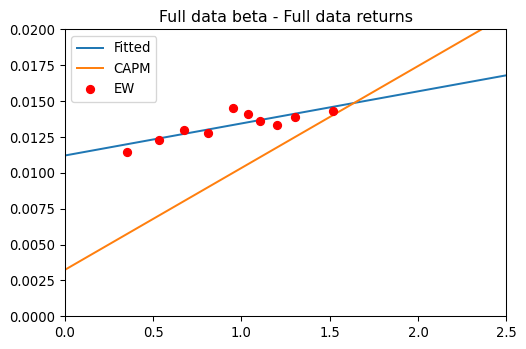

In [76]:
from sklearn.linear_model import LinearRegression

#fitting the line between beta and returns 
model = LinearRegression(fit_intercept=True)
x = np.array([beta_avg]).transpose()
y = np.array(ret_avg)
fit = model.fit(x,y)
b0 = fit.intercept_
b1=fit.coef_
beta_x = np.linspace(-1,2.5, 4)
ret_est = b0 + b1*beta_x



slope_capm = np.mean(vw_market - tbill.values).item()
b0_capm = tbill.mean().item()
ret_capm = b0_capm + slope_capm*beta_x


print(f"Average market excess return {np.mean(vw_market - tbill.values).item()}")
print(f"Slope of the fitted line {b1.item()}")


plt.plot(beta_x, ret_est, label="Fitted")
plt.plot(beta_x, ret_capm, label ="CAPM")
plt.setp(plt.gca(),ylim=(0,0.02))
plt.xlim(0,2.5)
plt.plot(beta_avg, ret_avg, marker="o", linestyle="None", color="red", label = "EW")
plt.title("Full data beta - Full data returns")
plt.legend()
plt.show()

#Comments
# We can see that the slope of the fitted line is flatter than the slope of the CAPM, the latter is in fact equal to the average
# market excess return.
# This means that our results do not seem consistent with the CAPM




In [6]:
data["market"] = vw_market   #including the market in the dataset 
train_data = data.loc[data.index<"2000-01-01"]  #selecting the data for getting beta 
rf_train = tbill.loc[tbill.index < "2000-01-01"]   #we do the same also for the risk free

excess_return_train = train_data.subtract( rf_train.values )    #as before we compute the betas
var = excess_return_train.market.var() 
cov = excess_return_train.cov()["market"][:-1]
beta_train = cov/var

beta_train = beta_train.sort_values(ascending=False)  #sorting the beta 
train_data = train_data.drop(columns="market")
data = data.drop(columns="market")


#we proceed in the same way as before 

#beta quantiles 
levels = np.linspace(0,1,11)
quant_train = beta_train.quantile(levels )

#we can recalculate or just taking the mean 

#we change slightly the function to calculate the beta of selected stock on new data 
def calc_avg_beta_test(df):
    average_return = (1/df.shape[1])*df.sum(1).mean()
    df_e = pd.DataFrame(index=tbill_test.index)
    df_e["mkt"] = vw_market.loc[vw_market.index>="2000-01-01"]
    df_e["ret"] = df.sum(1)*(1/df.shape[1])
    df_e = df_e.subtract(tbill_test.values)
    c_mat = df_e.cov()
    return [average_return, c_mat["mkt"]["ret"]/c_mat["mkt"]["mkt"] ]




beta_avg_test = []
ret_avg_test =[] 
beta_avg_in = []
ret_avg_in = []

data_test = data.loc[data.index>="2000-01-01"]   #out of sample dat a to test our beta 
tbill_test = tbill.loc[tbill.index >= "2000-01-01"]


for i in range(len(levels)-1):
    if i == len(levels)-2:
        c = (beta_train>=quant_train[levels[i]]) * (beta_train<=quant_train[levels[i+1]])
        df = data_test[beta_train[c].index] 
        beta_avg_test.append(calc_avg_beta_test(df)[1])
        ret_avg_test.append(calc_avg_beta_test(df)[0])
        
        
        df_in = train_data[beta_train[c].index]
        beta_avg_in.append(calc_avg_beta_2(df_in, beta_train[c])[1])
        #dataset containg assets corresponding to a quantile of beta 
        #here we need to include the last quantile otherwise we will have 
        #one less data
        
    else:
        c = (beta_train>=quant_train[levels[i]]) * (beta_train<quant_train[levels[i+1]])
        df = data_test[beta_train[c].index] 
        beta_avg_test.append(calc_avg_beta_test(df)[1])
        ret_avg_test.append(calc_avg_beta_test(df)[0])
        df_in = train_data[beta_train[c].index]
        beta_avg_in.append(calc_avg_beta_2(df_in, beta_train[c])[1])
        

#we can visualize the beta of the portfolios obtained 
print("Betas out of sample")
print(beta_avg_test, "\n\n")
print("Beta in sample")
print(beta_avg_in )

Betas out of sample
[0.41050803793174245, 0.613958260904747, 0.6719819354188518, 0.9598188626508312, 1.0119460150372952, 1.091851275801231, 1.2100492301763839, 1.162312470477614, 1.2187944278612621, 1.3623139080263893] 


Beta in sample
[0.3404053076898996, 0.611822434468688, 0.7550808095511834, 0.8453721241190568, 0.9229142673406804, 0.9892025551715697, 1.0629526629794337, 1.126939691583567, 1.2060758653968864, 1.4076878693977941]


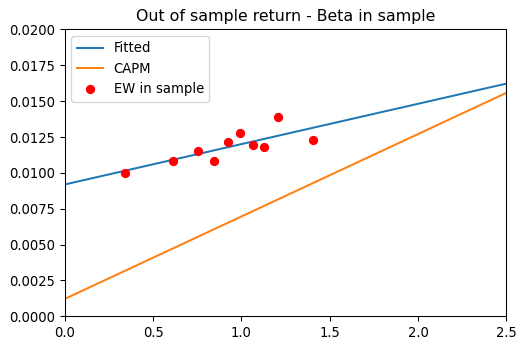

In [77]:
#out of sample return vr beta in sample 

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
x = np.array([beta_avg_in]).transpose()
y = np.array(ret_avg_test)
fit = model.fit(x,y)
b0 = fit.intercept_
b1=fit.coef_
beta_x = np.linspace(-0.1,2.5, 4)
ret_est = b0 + b1*beta_x



slope_capm_test = np.mean(vw_market.loc[vw_market.index>="2000-01-01"] - tbill_test.values).item()
b0_capm_test = tbill_test.mean().item()
ret_capm_test = b0_capm_test + slope_capm_test*beta_x


plt.plot(beta_x, ret_est, label="Fitted")
plt.setp(plt.gca(),ylim=(0,0.02))
plt.xlim((0,2.5))
plt.plot(beta_x, ret_capm_test, label = "CAPM")
plt.plot(beta_avg_in, ret_avg_test, marker="o", linestyle="None", color="red", label = "EW in sample")
#plt.plot(beta_avg_test, ret_avg_test, marker="o", linestyle="None", color="green", label = "EW out of sample")
plt.legend()
plt.title("Out of sample return - Beta in sample")
plt.show()


# We can see that also in this case the findings seems to be not consistent with the CAPM
# given the fact that the fitted line is flatter than the line implied by the CAPM


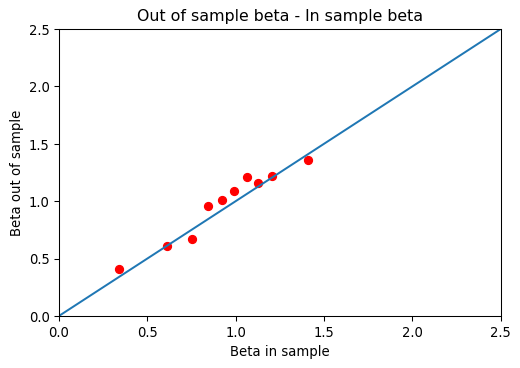

In [9]:
x = [-0.1,1,2.5]
plt.plot(beta_avg_in, beta_avg_test, marker="o", linestyle="None", color="red")
plt.plot(x, x)
plt.title("Out of sample beta - In sample beta")
plt.xlabel("Beta in sample")
plt.ylabel("Beta out of sample")
plt.xlim(0,2.5)
plt.ylim((0,2.5))
plt.show()


# From the plot we can see that the estimations of beta seems to be quite stable between in sample and out of sample 
# because the differences are not too large 

Annualized Mean of the Frazzini Portfolio: 0.21600744166510058
Annualized Mean of the Low Beta Portfolio: 0.1201316942887384
Annualized Mean of the High Beta Portfolio: 0.14721865292379968 

Annualized Std of the Frazzini Portfolio: 0.38289566414261184
Annualized Std of the Low Beta Portfolio: 0.14206804896810524
Annualized Std of the High Beta Portfolio: 0.24536374719346937 

Annualized Sharpe Ratio of the Frazzini Portfolio: 0.5262457355363253
Annualized Sharpe Ratio of the Low Beta Portfolio: 0.7434568419937178
Annualized Sharpe Ratio of the High Beta Portfolio: 0.5408640159234975


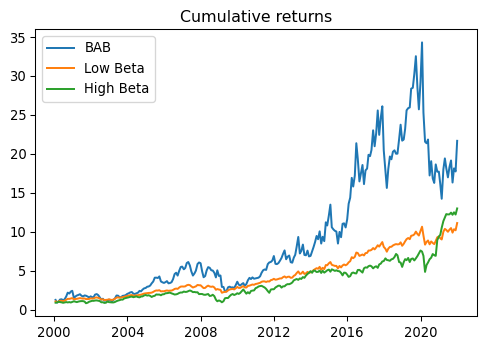

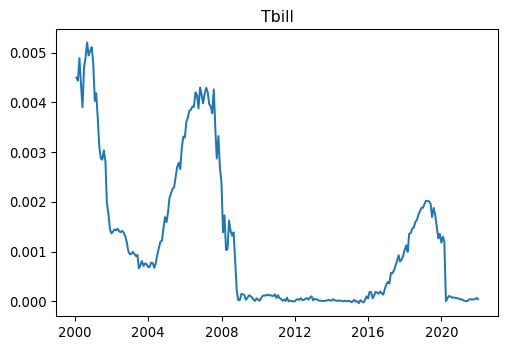

In [91]:
#Here we can now try the intuition of Frazzini 

low_beta = beta_avg_in[0]  #we take the lowest beta portfolio 
high_beta = beta_avg_in[9]  #we take the highest beta portfolio 

w_low = 1/low_beta  #weight for the portfolio
w_high = -1/high_beta   #weight for the portfolio 
w_rf = -(w_low + w_high)     #weight on the risk free 

c_low = (beta_train>=quant_train[levels[0]]) * (beta_train<quant_train[levels[1]])
port_low = data_test[beta_train[c_low].index]   #portofolio of low betas asset

c_high = (beta_train>=quant_train[levels[9]]) * (beta_train<=quant_train[levels[10]])
port_high = data_test[beta_train[c_high].index]  #portfolio of high betas asset 



portfolio = w_low * port_low.mean(1).values + w_high * port_high.mean(1).values + w_rf * tbill_test.values.reshape(-1)
port_frazzini = pd.DataFrame(portfolio, index=port_low.index)
port_frazzini["Low"] = plow
port_frazzini["High"] = phigh


m_port= portfolio.mean().item()
std_port = portfolio.std() 
sr_port = 12*(portfolio.mean() - tbill_test.mean())/ (std_port * np.sqrt(12) ) 

plow = port_low.mean(1)    #EW low beta portfolio
phigh = port_high.mean(1)    #EW high beta portfolio 

sr_low = 12*(plow.mean() - tbill_test.mean())/(plow.std() * np.sqrt(12)) #sharpe ratio
sr_high = 12*(phigh.mean() - tbill_test.mean())/(np.sqrt(12)*phigh.std())   #sharpe ratio 


print(f"Annualized Mean of the Frazzini Portfolio: {m_port*12}\nAnnualized Mean of the Low Beta Portfolio: {plow.mean()*12}\nAnnualized Mean of the High Beta Portfolio: {phigh.mean()*12} ")
print(f"\nAnnualized Std of the Frazzini Portfolio: {std_port*np.sqrt(12)}\nAnnualized Std of the Low Beta Portfolio: {plow.std()*np.sqrt(12)}\nAnnualized Std of the High Beta Portfolio: {phigh.std()*np.sqrt(12)} ")
print(f"\nAnnualized Sharpe Ratio of the Frazzini Portfolio: {sr_port.item()}")
print(f"Annualized Sharpe Ratio of the Low Beta Portfolio: {sr_low.item()}")
print(f"Annualized Sharpe Ratio of the High Beta Portfolio: {sr_high.item()}")


plt.plot( (port_frazzini + 1).cumprod() ,label =["BAB", "Low Beta", "High Beta"] )

plt.title("Cumulative returns")
plt.legend()
plt.show()

plt.plot( (tbill_test ) ,label ="tbill" )
plt.title("Tbill")
plt.show()


# we can see that this strategy does not seem to outperfom in the out of sample period 
# one possibile reason could be the fact that this portfolio is highly leveraged 
# and therefore the performance is highly sensitive to the risk free path 
# from the last plot we can see that the risk free has experienced large fluctuations 
